# Figure 5

## Figure 5c

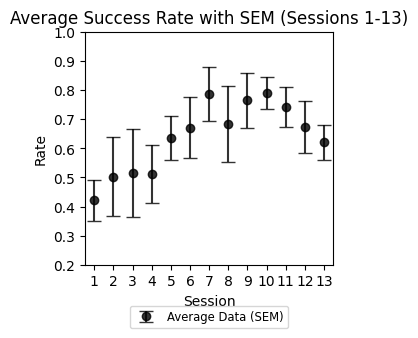

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the source data folder
source_folder = "../Source data/Figure 5"
npz_file_path = os.path.join(source_folder, "success_rate_data.npz")

# Load the npz file
loaded_data = np.load(npz_file_path)
x_avg_loaded = loaded_data["x_avg"]
y_avg_loaded = loaded_data["y_avg"]
y_sem_loaded = loaded_data["y_sem"]

# Recreate the plot
plt.figure(figsize=(3.3, 4))
plt.errorbar(x_avg_loaded, y_avg_loaded, yerr=y_sem_loaded, fmt='o', color='black', label='Average Data (SEM)', alpha=0.8, capsize=5)

# Customize the plot
plt.title("Average Success Rate with SEM (Sessions 1-13)")
plt.xlabel("Session")
plt.ylabel("Rate")
plt.xlim(0.5, 13.5)
plt.ylim(0.2, 1)
plt.xticks(np.arange(1, 14))

# Move the legend outside the plot
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), fontsize="small", ncol=2)
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend

# Save and show the plot
# plt.savefig("success_rate_plot_from_npz.pdf")
plt.show()

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Function to calculate significance stars
def get_significance_stars(p_value):
    """ Return stars based on p-value thresholds. """
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'

# Load the NPZ success rate data
npz_file_path = "../Source data/Figure 5/success_rate_data.npz"
loaded_data = np.load(npz_file_path)

# Extract session data and success rates
session_numbers = loaded_data["x_avg"]  # Sessions 1-13
success_rates = loaded_data["y_avg"]  # Corresponding success rates

# Create a DataFrame
success_rate_df = pd.DataFrame({
    "session": session_numbers,
    "success_rate": success_rates
})

# Group sessions into 1-4, 5-9, 10-13
def group_sessions(data):
    data['group'] = pd.cut(data['session'], bins=[0, 4, 9, 13], labels=['1-4', '5-9', '10-13'])
    return data

# Apply grouping
grouped_data = group_sessions(success_rate_df)

# Calculate overall averages for each group
overall_group_means = grouped_data.groupby(['group'])['success_rate'].mean().reset_index()
print("Overall Group Means:\n", overall_group_means)

# Extract success rates for each group across all subjects
groups = ['1-4', '5-9', '10-13']
group_data = {group: grouped_data[grouped_data['group'] == group]['success_rate'] for group in groups}

# Perform pairwise comparisons between group averages
comparisons = [('1-4', '5-9'), ('5-9', '10-13'), ('1-4', '10-13')]
for g1, g2 in comparisons:
    if len(group_data[g1]) > 0 and len(group_data[g2]) > 0:  # Ensure there is data for both groups
        t_stat, p_value = ttest_ind(group_data[g1], group_data[g2], equal_var=False)  # Welch's t-test
        stars = get_significance_stars(p_value)
        print(f"Comparison {g1} vs {g2}: p-value = {p_value:.5f} ({stars})")

Overall Group Means:
    group  success_rate
0    1-4        0.4875
1    5-9        0.7080
2  10-13        0.7060
Comparison 1-4 vs 5-9: p-value = 0.00052 (***)
Comparison 5-9 vs 10-13: p-value = 0.96759 (n.s.)
Comparison 1-4 vs 10-13: p-value = 0.00440 (**)


## Figure 5d

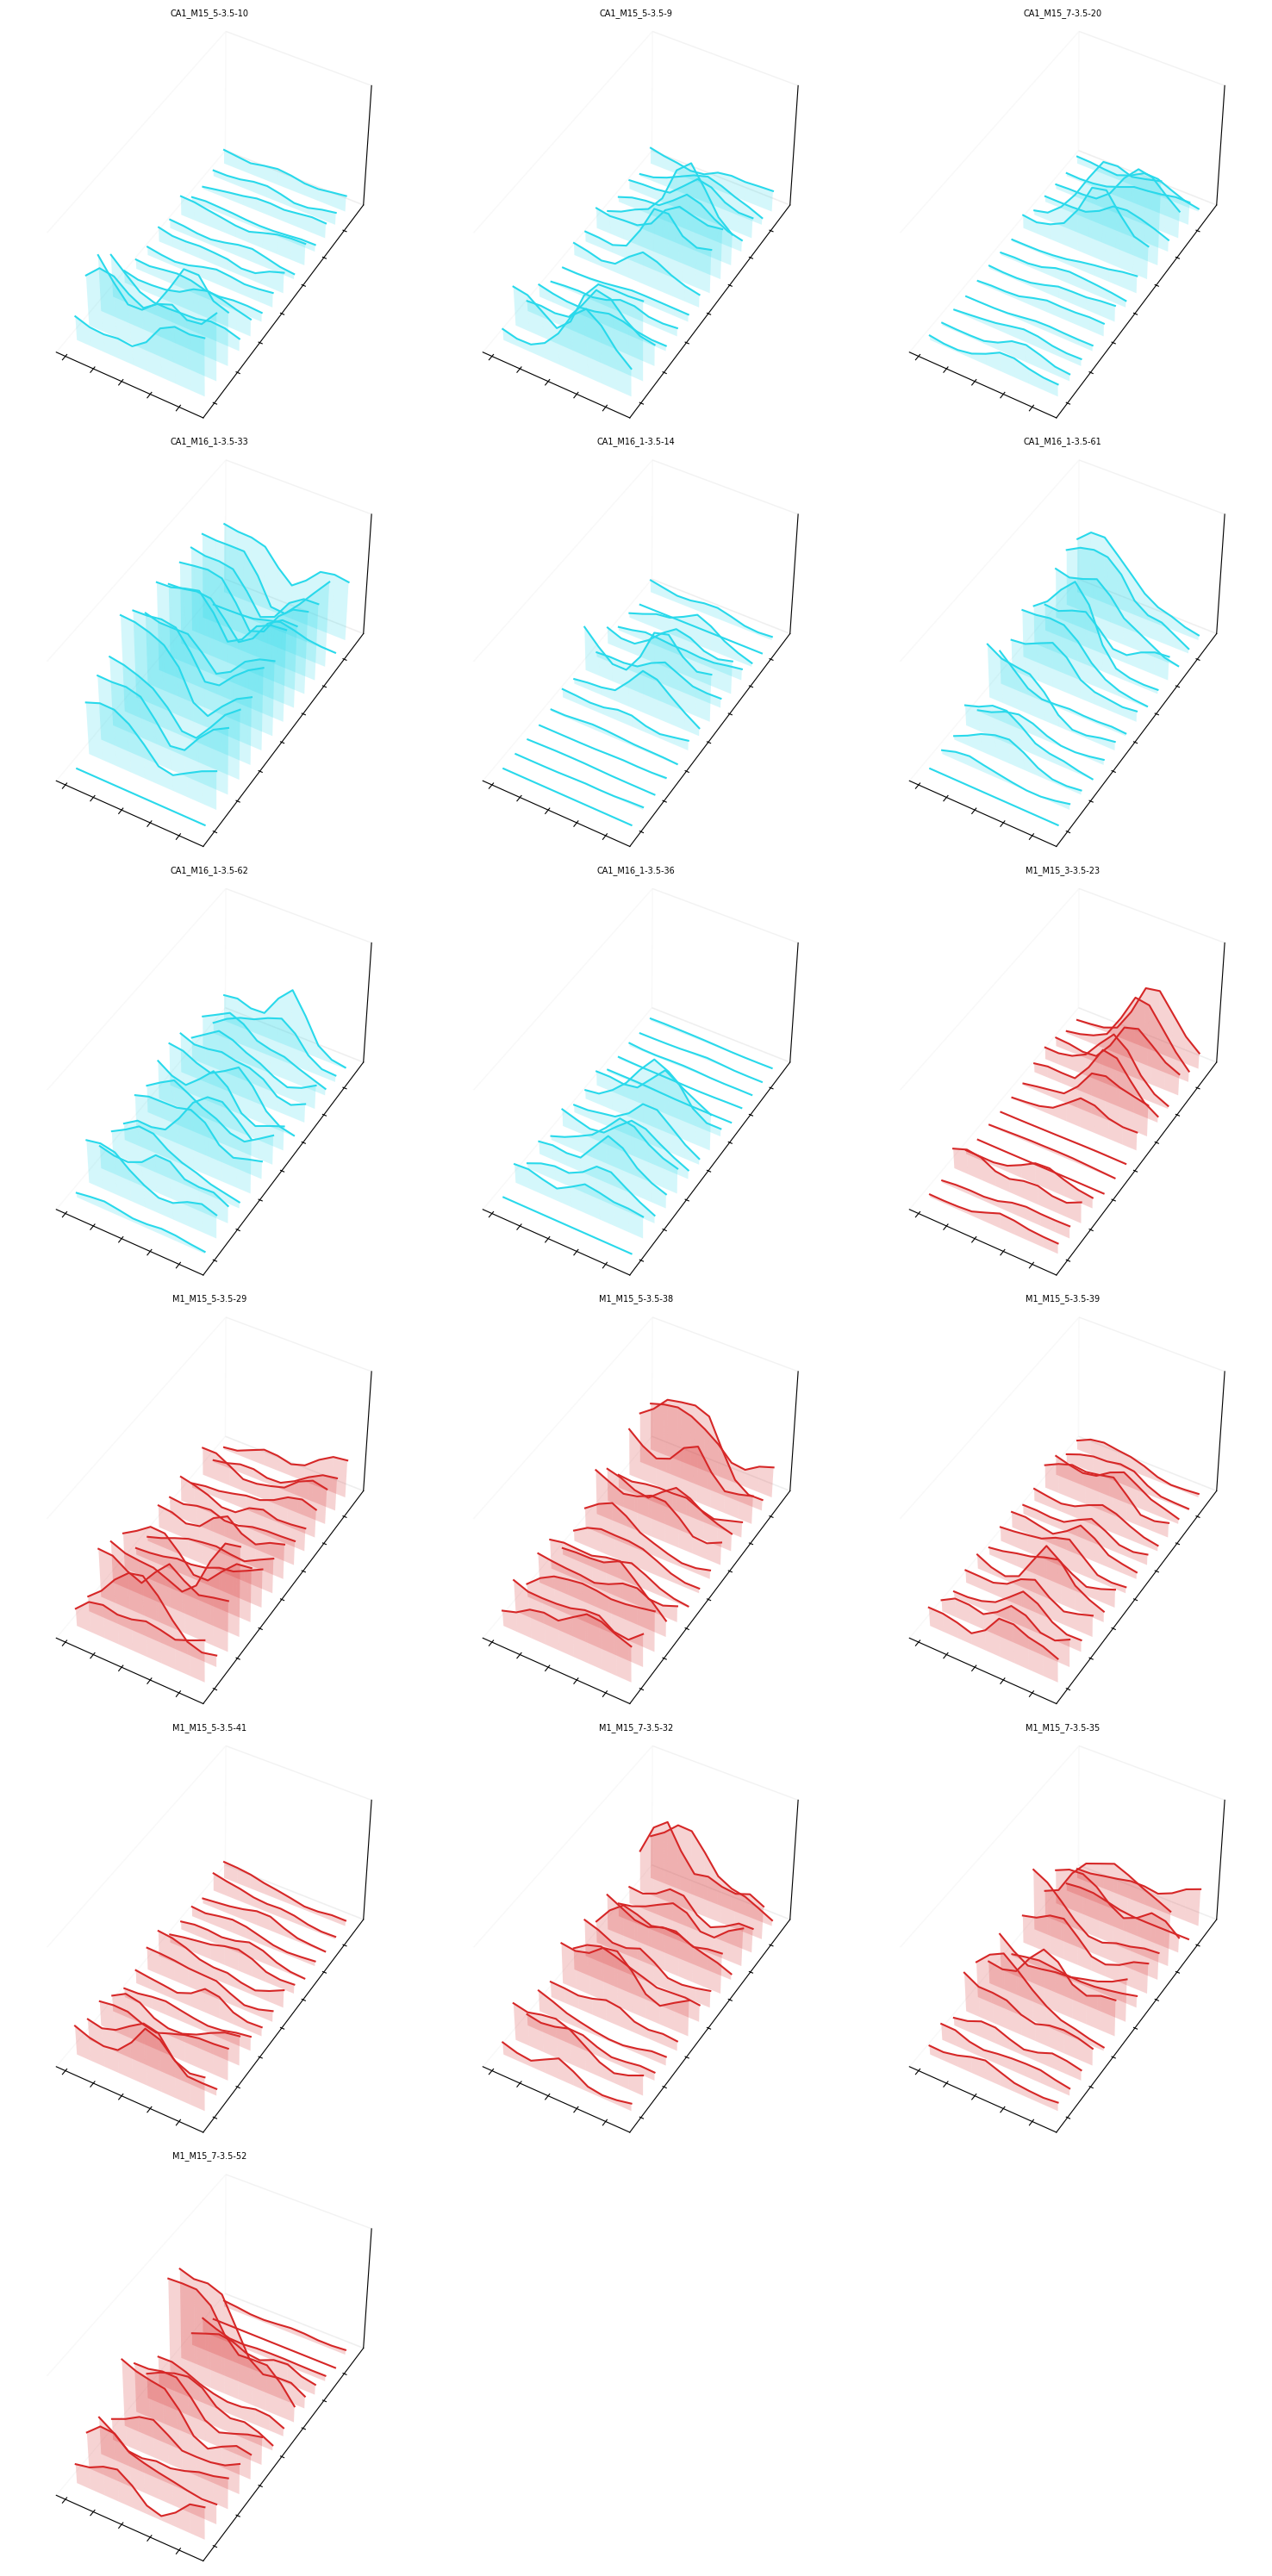

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import gaussian_filter1d

# === Load data ===
npz_file_path = "../Source data/Figure 5/psth_data.npz"
data_dict = np.load(npz_file_path, allow_pickle=True)

# === Selected units to plot ===
selected_units = [
    "CA1_M16_1-3.5-61", "CA1_M15_5-3.5-9", "CA1_M15_7-3.5-20", "CA1_M16_1-3.5-14",
     "CA1_M16_1-3.5-36", "CA1_M16_1-3.5-62", "CA1_M15_5-3.5-10",
    "CA1_M16_1-3.5-33", "M1_M15_7-3.5-32", "M1_M15_3-3.5-23", "M1_M15_5-3.5-38",
    "M1_M15_7-3.5-52", "M1_M15_5-3.5-41", "M1_M15_7-3.5-35", "M1_M15_5-3.5-29",
    "M1_M15_5-3.5-39"
]

# === Filter only selected units ===
filtered_unit_keys = [k for k in data_dict.files if k in selected_units]

# === Determine layout ===
n_files = len(filtered_unit_keys)
n_cols = 3
n_rows = (n_files // n_cols) + (1 if n_files % n_cols != 0 else 0)

# === Create subplots ===
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), subplot_kw={"projection": "3d"})
axes = np.array(axes).flatten()

# === Iterate over selected units ===
for idx, unit_key in enumerate(filtered_unit_keys):
    unit_data = data_dict[unit_key].item()
    region = unit_data["region"]
    data = unit_data["data"]

    # Set color by region
    color = "#29d9eb" if region == "CA1" else "#d62727" if region == "M1" else "gray"

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["segment", "time", "offsetted firing counts"])

    # Group by segment
    sorted_segments = df.groupby("segment")
    sorted_segments = sorted(sorted_segments, key=lambda x: x[0])

    # Get corresponding subplot axis
    ax = axes[idx]
    ax.set_facecolor("white")
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_zticks([])
    ax.set_zticklabels([])
    ax.tick_params(axis="x", which="both", labelbottom=False)
    ax.tick_params(axis="y", which="both", labelleft=False)

    # === Plot each segment ===
    for segment_idx, (segment, segment_data) in enumerate(sorted_segments):
        time = segment_data["time"].values
        firing_rate = gaussian_filter1d(segment_data["offsetted firing counts"].values, sigma=1)
        segments = [segment_idx] * len(time)

        # Plot the curve
        ax.plot(time, segments, firing_rate, color=color, label=f"Segment {segment}")

        # Add filling under curve
        verts = []
        for i in range(len(time) - 1):
            verts.append([
                (time[i], segments[i], 0),
                (time[i], segments[i], firing_rate[i]),
                (time[i + 1], segments[i + 1], firing_rate[i + 1]),
                (time[i + 1], segments[i + 1], 0)
            ])
        poly = Poly3DCollection(verts, color=color, alpha=0.2, edgecolor="none")
        ax.add_collection3d(poly)

    # Set z axis limit and view
    ax.set_zlim(0, 1)
    ax.set_title(f"{unit_key}", fontsize=7)
    ax.set_box_aspect([1, 2, 1])
    ax.view_init(45, -60)

# Hide unused axes
for j in range(len(filtered_unit_keys), len(axes)):
    fig.delaxes(axes[j])

# === Final layout ===
plt.tight_layout()
plt.show()


## Figure 5e

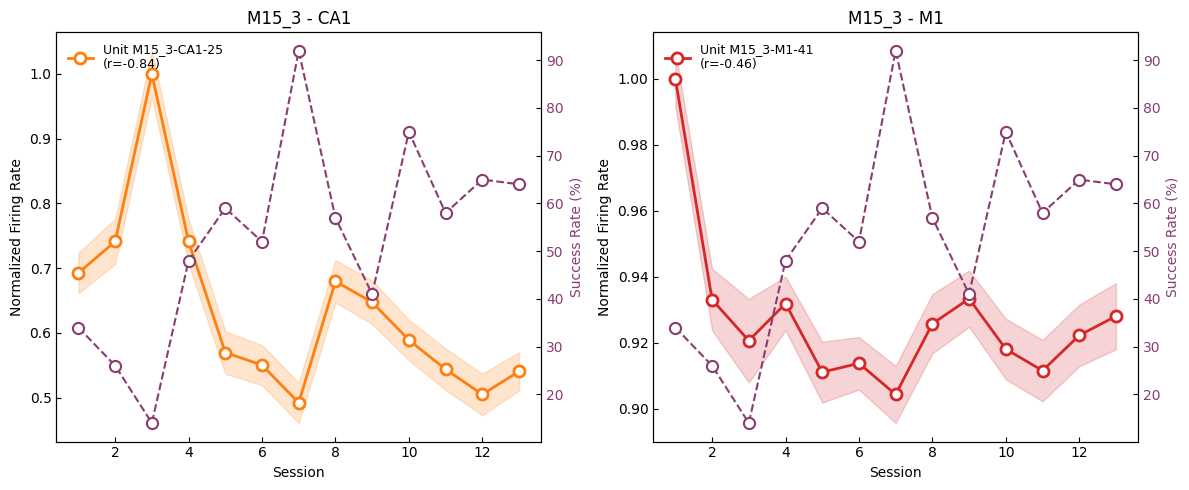

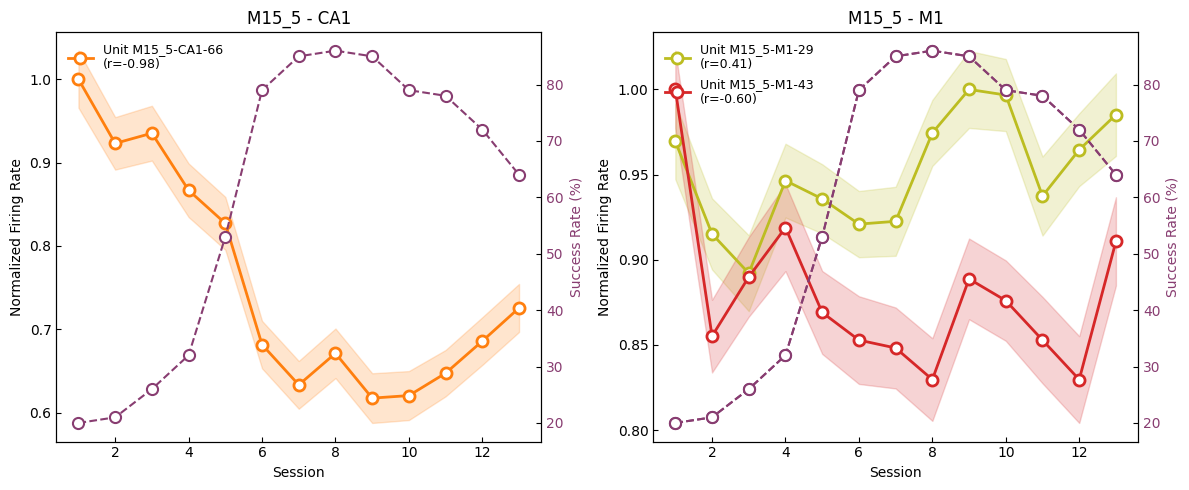

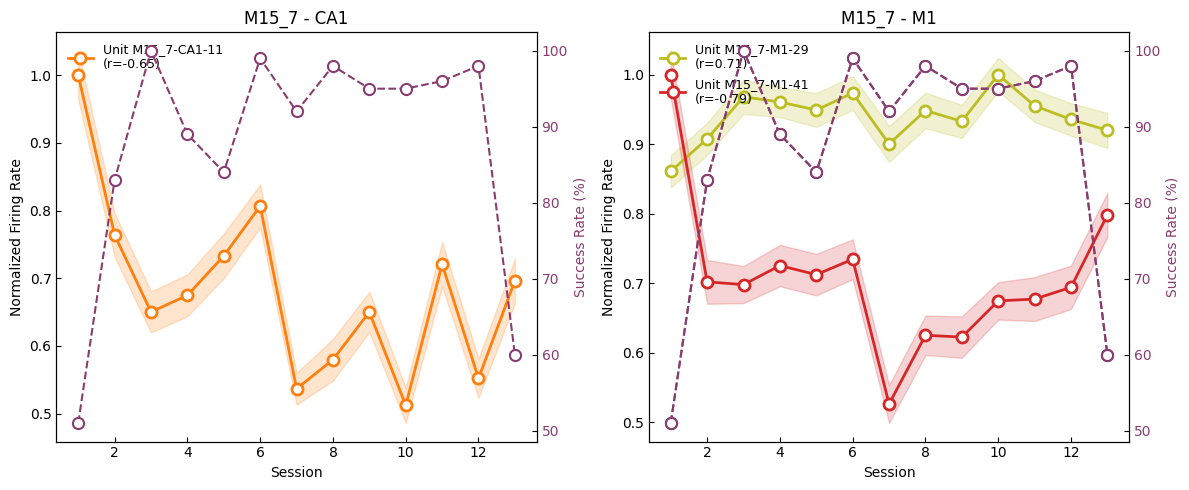

Redrawing complete, ensuring it matches the original visualization with two plots per row (CA1, M1), including correlation coefficients!


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load .npz file
npz_file_path = "../Source data/Figure 5/firing_success_data.npz"
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Color scheme
region_colors = {
    "CA1": {"positive": "#1f77b4", "negative": "#ff7f0e"},  # Blue and Orange
    "M1": {"positive": "#bcbd21", "negative": "#d62728"}    # Green and Red
}
behavior_color = "#883d71"  # Purple

# Organizing data (grouped by subject)
subject_groups = {}

for key in loaded_data.files:
    parts = key.rsplit("_", 1)  # Split at the last "_"
    
    if len(parts) != 2:
        print(f"⚠️ Skipping invalid key: {key}")
        continue
    
    subject_id, region_id = parts
    if subject_id not in subject_groups:
        subject_groups[subject_id] = {}
    subject_groups[subject_id][region_id] = loaded_data[key]

# Start plotting
for subject_id, regions in subject_groups.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    region_order = ["CA1", "M1"]
    
    for ax, region_id in zip(axes, region_order):
        if region_id not in regions:
            ax.axis("off")  # Hide the plot if there is no data for this region
            continue
        
        ax_right = ax.twinx()
        neurons = regions[region_id]
        
        for neuron in neurons:
            unit_key, corr, firing_rates, success_rates, sem_values = (
                neuron["unit_key"],
                neuron["corr"],
                neuron["firing_rates"],
                neuron["success_rates"],
                neuron["sem_values"],
            )
            
            sessions = range(1, 14)
            color = region_colors[region_id]["positive"] if corr > 0 else region_colors[region_id]["negative"]
            
            ax.plot(
                sessions, firing_rates, '-o',
                label=f"Unit {unit_key}\n(r={corr:.2f})",  # Show unit ID and correlation coefficient
                linewidth=2, color=color,
                markerfacecolor="white", markeredgewidth=2, markersize=8
            )
            
            ax.fill_between(
                sessions,
                firing_rates - sem_values,
                firing_rates + sem_values,
                color=color, alpha=0.2
            )
            
            ax_right.plot(
                sessions, success_rates * 100, '--o',
                label="Success Rate", color=behavior_color,
                linewidth=1.5, markerfacecolor="white", markeredgewidth=1.5, markersize=8
            )
        
        ax.set_xlabel("Session")
        ax.set_ylabel("Normalized Firing Rate")
        ax_right.set_ylabel("Success Rate (%)", color=behavior_color)
        ax.set_title(f"{subject_id} - {region_id}")
        ax.tick_params(axis='both', direction='in')
        ax_right.tick_params(axis='both', direction='in', labelcolor=behavior_color)

        # Add a legend for each plot
        ax.legend(loc="upper left", fontsize=9, frameon=False)

    plt.tight_layout()
    # plt.savefig(f"{subject_id}_firing_vs_success.pdf", format="pdf")
    plt.show()

print("Redrawing complete, ensuring it matches the original visualization with two plots per row (CA1, M1), including correlation coefficients!")

## Figure 5f

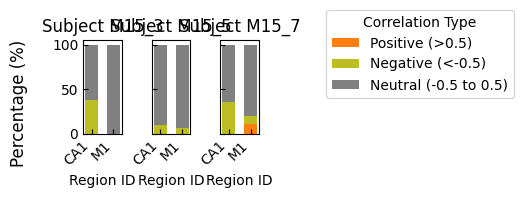

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Load the saved correlation data
npz_file_path = "../Source data/Figure 5/correlation_data.npz"
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Define target subjects
target_subjects = ["M15_3", "M15_5", "M15_7"]

# Define colors
region_color_cycle = cycle(plt.cm.tab10.colors)
region_colors = {}

# Organize the data for plotting
subject_groups = {}

for key in loaded_data.files:
    data = loaded_data[key].item()
    subject_id, region_id, unit_key = data["subject"], data["region"], data["unit_key"]
    correlation = data["correlation"]

    if subject_id not in target_subjects:
        continue  # Skip subjects not in the target list

    if subject_id not in subject_groups:
        subject_groups[subject_id] = {}

    if region_id not in subject_groups[subject_id]:
        subject_groups[subject_id][region_id] = []

    subject_groups[subject_id][region_id].append((unit_key, correlation))

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(3, 2), sharey=True)

for ax, (subject_id, regions) in zip(axes, list(subject_groups.items())):
    correlations_by_region = {}

    for region_id, units in regions.items():
        if region_id not in region_colors:
            region_colors[region_id] = next(region_color_cycle)

        if region_id not in correlations_by_region:
            correlations_by_region[region_id] = {"positive": 0, "negative": 0, "neutral": 0}

        for unit_key, corr in units:
            if corr > 0.5:
                correlations_by_region[region_id]["positive"] += 1
            elif corr < -0.5:
                correlations_by_region[region_id]["negative"] += 1
            else:
                correlations_by_region[region_id]["neutral"] += 1

    # Prepare data for stacked bar plot
    region_labels = []
    positive_percents = []
    negative_percents = []
    neutral_percents = []

    for region_id, counts in correlations_by_region.items():
        total = sum(counts.values())
        if total > 0:
            region_labels.append(region_id)
            positive_percents.append((counts["positive"] / total) * 100)
            negative_percents.append((counts["negative"] / total) * 100)
            neutral_percents.append((counts["neutral"] / total) * 100)

    # Plot stacked bars
    bar_width = 0.3
    x = np.arange(len(region_labels)) * 0.5 + 2

    ax.bar(x, positive_percents, width=bar_width, label="Positive (>0.5)", color="#fe7f0e")
    ax.bar(x, negative_percents, width=bar_width, bottom=positive_percents, label="Negative (<-0.5)", color="#bcbd21")
    ax.bar(x, neutral_percents, width=bar_width, bottom=np.array(positive_percents) + np.array(negative_percents), label="Neutral (-0.5 to 0.5)", color="gray")

    ax.set_title(f"Subject {subject_id}")
    ax.set_xlabel("Region ID")
    ax.set_xticks(x)
    ax.set_xticklabels(region_labels, rotation=45, ha="right")
    ax.tick_params(axis="both", direction="in")

# Set shared labels and legend
fig.supylabel("Percentage (%)")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc="upper left", title="Correlation Type")

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()